# Evaluate surface tracing

This notebook compares the results of two different approaches to surface tracing:

- Approach 1: Matlab code published [here](https://github.com/campaslab/STRESS)
- Approach2: Napari surface tracing demonstrated in [this notebook ](./Process_confocal.ipynb)

In [1]:
import numpy as np
from scipy import io
import os
import pandas as pd

import napari_stress
from napari_stress._utils import time_slicer

import napari
import matplotlib.pyplot as plt

In [2]:
viewer = napari.Viewer()

Assistant skips harvesting pyclesperanto as it's not installed.


In [3]:
root = r'C:\Users\johamuel\Documents\BiAPoL\Shared\BiAPoLprojects\20_STRESS\1_first_data'

raw_image = os.path.join(root,
                         'ExampleTifSequence-InteriorLabel-vsx_2.076um-vsz_3.998um-TimeInterval_3.00min-21timesteps.tif')
matlab_results = os.path.join(root, 
                             'results_matlab_code',
                             'ExampleTifSequence-InteriorLabel--21timesteps_analyzed',
                             'CoordsAndCurves_2022_4_28_14_59')
napari_results = os.path.join(root,
                              'ExampleTifSequence-InteriorLabel-vsx_2.076um-vsz_3.998um-TimeInterval_3.00min-21timesteps_analyzed.csv')

In [4]:
vsz = 3.998
vsy = 2.076
vsx = 2.076

In [5]:
viewer.open(raw_image, scale = np.asarray([vsz, vsy, vsx]))

[<Image layer 'ExampleTifSequence-InteriorLabel-vsx_2.076um-vsz_3.998um-TimeInterval_3.00min-21timesteps' at 0x2f4504c9ac0>]

This thing helps us to convert back and forth between lists of points (e.g. one entry for every frame) and 4D pointcloud sets that are compatible with Napari

In [6]:
Converter = time_slicer.Converter()

## Loading data from Matlab

The matlab results are loaded as a Python dictionary with the following column headers:

In [7]:
matlab_data = []

for f in os.listdir(matlab_results):
    matlab_data.append(io.loadmat(os.path.join(matlab_results, f)))
matlab_data[0].keys()
matlab_points = [x['pointCloudArray'] for x in matlab_data]

## Loading data from Python

The results from Python are stored as .csv files that can be read with the Pandas package

In [8]:
python_data = pd.read_csv(napari_results, sep='\t')
python_data

,Unnamed: 0,t,x1,x2,x3,fit_residues,curvatures
0,0,0.0,29.606052,28.750132,20.178068,3.468589,0.005049
1,1,0.0,28.753433,30.732504,20.111330,3.432343,0.004903
2,2,0.0,26.274553,30.055321,20.409670,3.050843,0.004945
3,3,0.0,29.655508,31.567692,19.915390,3.299975,0.005598
4,4,0.0,32.183094,28.610729,20.381533,3.433988,0.005524
...,...,...,...,...,...,...,...
8230,8230,20.0,32.288338,27.393843,47.022659,1.809680,0.005452
8231,8231,20.0,27.130127,27.070652,47.361084,1.375345,0.006046
8232,8232,20.0,28.499922,28.843052,47.248196,1.514098,0.005790
8233,8233,20.0,30.594978,25.254051,47.312160,1.790700,0.005819


In [9]:
# Convert both arrays to arrays
verts_python = python_data[['t', 'x1', 'x2', 'x3']].to_numpy()
verts_matlab = Converter.list_of_data_to_data(matlab_points, layertype=napari.types.PointsData)

In [10]:
# Multiply matlab points by dimensions
verts_matlab = verts_matlab * np.asarray([1, vsx, vsx, vsx])[None, :]

In [11]:
verts_matlab_copy = np.zeros_like(verts_matlab)

verts_matlab_copy[:, 0] = verts_matlab[:, 0]
verts_matlab_copy[:, 1] = verts_matlab[:, 3]
verts_matlab_copy[:, 2] = verts_matlab[:, 2]
verts_matlab_copy[:, 3] = verts_matlab[:, 1]

We could first ask ourselves: by how many points is the surface characterized?

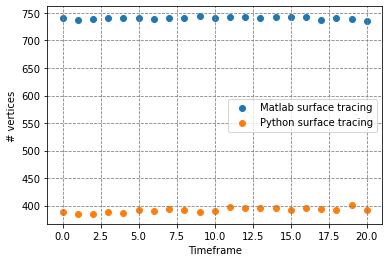

In [12]:
_verts_python = Converter.data_to_list_of_data(verts_python, layertype=napari.types.PointsData)
_verts_matlab = Converter.data_to_list_of_data(verts_matlab_copy, layertype=napari.types.PointsData)

n_verts_matlab = [len(x) for x in _verts_matlab]
n_verts_python = [len(x) for x in _verts_python]
t = np.arange(len(matlab_points))

fig, ax = plt.subplots()
ax.scatter(t, n_verts_matlab, label = 'Matlab surface tracing')
ax.scatter(t, n_verts_python, label = 'Python surface tracing')
ax.set_xlabel('Timeframe')
ax.set_ylabel('# vertices')
ax.grid(which='major', linestyle='--', color='gray')
ax.legend()

In [13]:
viewer.add_points(verts_matlab_copy, name='Matlab points', face_color='blue', size=1)
viewer.add_points(verts_python, name='Python points', face_color='orange', size=1)

<Points layer 'Python points' at 0x2f460ea0d30>

## Curvature

Now, let's compare curvatures of both methods

In [14]:
mean_curvatures_matlab = [x['meanCurvatureArray'] for x in matlab_data]
mean_curvatures_python = [
    python_data[python_data['t'] == t]['curvatures'].to_numpy() for t in python_data['t'].unique().astype(int)
]

We will compare the mean curvatures of both datasets by means of

- mean curvature of all vertices
- median curvature of all vertices
- 25/75% percentile curvature of all vertices

...for every frame

In [17]:
curv_mean_python = [np.sqrt(np.mean(x)) for x in mean_curvatures_python]
curv_median_python = [np.sqrt(np.median(x)) for x in mean_curvatures_python]

curv_mean_matlab = [np.mean(x) for x in mean_curvatures_matlab]
curv_median_matlab = [np.median(x) for x in mean_curvatures_matlab]

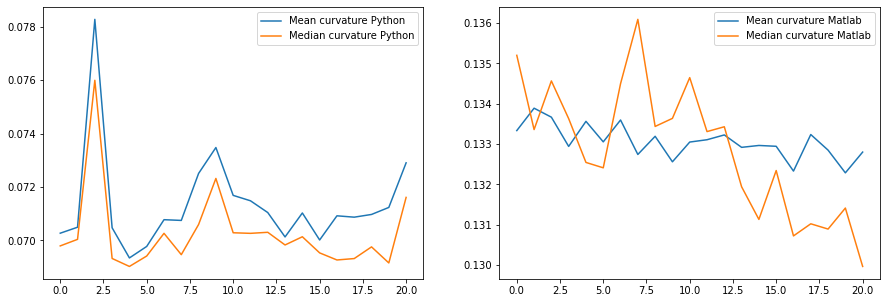

In [18]:
fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))

axes[0].plot(t, curv_mean_python, label = 'Mean curvature Python')
axes[0].plot(t, curv_median_python, label = 'Median curvature Python')
axes[0].legend()


axes[1].plot(t, curv_mean_matlab, label = 'Mean curvature Matlab')
axes[1].plot(t, curv_median_matlab, label = 'Median curvature Matlab')
axes[1].legend()